# 初期設定

In [2]:
from typing import *
import os
from glob import glob
from datetime import datetime
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nptyping import NDArray
from minepy import MINE as Mine
from crypto_data_fetcher.gmo import GmoFetcher
from scipy.stats import ttest_1samp
import talib
import shap
import numba

# 機械学習ライブラリ
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report, f1_score, r2_score
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LogisticRegression
import joblib

sns.set_style('whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# データ読み込み

In [3]:
df = pd.read_csv('ohlcv_15min_1112.csv')
display(df)

# ETH
df_eth = pd.read_csv('ohlcv_15min_1112_eth.csv')
display(df_eth)

# XRP
df_xrp = pd.read_csv('ohlcv_15min_1112_xrp.csv')
display(df_xrp)

,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,8297.5,8340.0,8227.0,8253.0,15208339
1,2019-10-01 00:15:00+00:00,8253.0,8264.0,8226.0,8231.5,6727155
2,2019-10-01 00:30:00+00:00,8231.5,8236.0,8214.0,8236.0,7055839
3,2019-10-01 00:45:00+00:00,8236.0,8236.0,8220.0,8225.0,2851351
4,2019-10-01 01:00:00+00:00,8225.0,8235.0,8199.0,8228.5,8568631
...,...,...,...,...,...,...
74299,2021-11-12 22:45:00+00:00,64093.0,64099.0,63725.5,63948.5,31085187
74300,2021-11-12 23:00:00+00:00,63948.5,64043.0,63948.5,64015.5,9639935
74301,2021-11-12 23:15:00+00:00,64015.5,64068.5,63921.5,63994.0,9049677
74302,2021-11-12 23:30:00+00:00,63994.0,64092.5,63867.0,63867.0,12635332


,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,181.25,181.70,179.55,180.10,911858
1,2019-10-01 00:15:00+00:00,180.15,180.35,179.05,179.90,1259103
2,2019-10-01 00:30:00+00:00,179.90,179.90,178.65,179.05,623606
3,2019-10-01 00:45:00+00:00,179.10,179.10,178.65,179.05,368355
4,2019-10-01 01:00:00+00:00,179.05,179.15,178.30,178.80,617389
...,...,...,...,...,...,...
74299,2021-11-12 22:45:00+00:00,4650.95,4650.95,4633.10,4643.95,7223354
74300,2021-11-12 23:00:00+00:00,4644.10,4656.95,4644.05,4656.90,4702013
74301,2021-11-12 23:15:00+00:00,4656.90,4660.25,4652.15,4656.95,2407601
74302,2021-11-12 23:30:00+00:00,4658.75,4671.10,4644.35,4648.85,7966782


,timestamp,open,high,low,close,volume
0,2019-10-01 00:00:00+00:00,0.2572,0.2578,0.2546,0.2553,722844
1,2019-10-01 00:15:00+00:00,0.2554,0.2554,0.2545,0.2551,276482
2,2019-10-01 00:30:00+00:00,0.2549,0.2550,0.2541,0.2545,388315
3,2019-10-01 00:45:00+00:00,0.2544,0.2547,0.2542,0.2542,845748
4,2019-10-01 01:00:00+00:00,0.2542,0.2543,0.2530,0.2539,340968
...,...,...,...,...,...,...
74299,2021-11-12 22:45:00+00:00,1.1927,1.1927,1.1865,1.1919,1350897
74300,2021-11-12 23:00:00+00:00,1.1920,1.1935,1.1898,1.1905,763830
74301,2021-11-12 23:15:00+00:00,1.1905,1.1940,1.1885,1.1897,1898398
74302,2021-11-12 23:30:00+00:00,1.1898,1.1916,1.1873,1.1876,1634083


In [4]:
df['fee'] = -0.00025
display(df)
df.to_pickle('df_ohlcv_with_fee.pkl')

,timestamp,open,high,low,close,volume,fee
0,2019-10-01 00:00:00+00:00,8297.5,8340.0,8227.0,8253.0,15208339,-0.00025
1,2019-10-01 00:15:00+00:00,8253.0,8264.0,8226.0,8231.5,6727155,-0.00025
2,2019-10-01 00:30:00+00:00,8231.5,8236.0,8214.0,8236.0,7055839,-0.00025
3,2019-10-01 00:45:00+00:00,8236.0,8236.0,8220.0,8225.0,2851351,-0.00025
4,2019-10-01 01:00:00+00:00,8225.0,8235.0,8199.0,8228.5,8568631,-0.00025
...,...,...,...,...,...,...,...
74299,2021-11-12 22:45:00+00:00,64093.0,64099.0,63725.5,63948.5,31085187,-0.00025
74300,2021-11-12 23:00:00+00:00,63948.5,64043.0,63948.5,64015.5,9639935,-0.00025
74301,2021-11-12 23:15:00+00:00,64015.5,64068.5,63921.5,63994.0,9049677,-0.00025
74302,2021-11-12 23:30:00+00:00,63994.0,64092.5,63867.0,63867.0,12635332,-0.00025


# 通貨間相関

In [5]:
def calc_mic(x, y):
    # MINEインスタンスを作成
    mine = Mine()
    # MINEで解析処理を実行
    mine.compute_score(x, y)
    # MICの値を取得
    return mine.mic()

# print('BTC vs. ETH mic: ', calc_mic(x=df_eth['close'].values, y=df['close'].values))
# print('BTC vs. XRP mic: ', calc_mic(x=df_xrp['close'].values, y=df['close'].values))

# 特徴量生成

In [6]:
def calc_features(df):
    open = df['open']
    high = df['high']
    low = df['low']
    close = df['close']
    volume = df['volume']
    
    orig_columns = df.columns

    hilo = (df['high'] + df['low']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    df['pct'] = df['close'].pct_change()  # 変化率
    df['cr_std_25']= df['pct'].rolling(25).std()  # 変化率の偏差

    def up_hige_size(df):
        """上ヒゲの大きさ"""
        df = df.copy()
        uphige = np.zeros(len(df))
        high = df.high.values
        close = df.close.values
        open_ = df.open.values
        # close とopenの高い方を判定
        close_or_open = df.open.values - df.close.values
        close_or_open_sign = np.sign(close_or_open)
        close_or_open_sign = np.where(close_or_open_sign == 0, 1, close_or_open_sign)
        # 陽線
        for i in range(len(close_or_open_sign)):
            sig = close_or_open_sign[i]
            h = high[i]
            o = open_[i]
            c = close[i]
            if sig == 1:
                uphige[i] = (h - o) / c
            else:
                uphige[i] = (h - c) / c
        uphige = uphige/close
        return uphige

    def down_hige_size(df):
        """下ヒゲの大きさ"""
        df = df.copy()
        downhige = np.zeros(len(df))
        low = df.low.values
        close = df.close.values
        open_ = df.open.values
        # close とopenの高い方を判定
        close_or_open = df.open.values - df.close.values
        close_or_open_sign = np.sign(close_or_open)
        close_or_open_sign = np.where(close_or_open_sign == 0, 1, close_or_open_sign)
        # 陽線
        for i in range(len(close_or_open_sign)):
            sig = close_or_open_sign[i]
            l = low[i]
            o = open_[i]
            c = close[i]

            if sig == 1:
                downhige[i] = (c - l) / c
            else:
                downhige[i] = (o - l) / c
        downhige = downhige/close
        return downhige
    
    df['uphige_size'] = up_hige_size(df)
    df['downhige_size'] = down_hige_size(df)

    return df


df = pd.read_pickle('df_ohlcv_with_fee.pkl')
df = df.dropna()
df = calc_features(df)
# display(df)

df_eth = df_eth.dropna()
df_eth = calc_features(df_eth)


df = pd.merge(df, df_eth, on='timestamp', suffixes=['', '_eth']).set_index('timestamp')

display(df)

df.to_pickle('df_features.pkl')

,open,high,low,close,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,SMA,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,BOP,CCI,DX,MACD_macd,MACD_macdsignal,MACD_macdhist,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,RSI,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,TRANGE,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,pct,cr_std_25,uphige_size,downhige_size,open_eth,high_eth,low_eth,close_eth,volume_eth,BBANDS_upperband_eth,BBANDS_middleband_eth,BBANDS_lowerband_eth,DEMA_eth,EMA_eth,HT_TRENDLINE_eth,KAMA_eth,MA_eth,MIDPOINT_eth,SMA_eth,T3_eth,TEMA_eth,TRIMA_eth,WMA_eth,ADX_eth,ADXR_eth,APO_eth,AROON_aroondown_eth,AROON_aroonup_eth,AROONOSC_eth,BOP_eth,CCI_eth,DX_eth,MACD_macd_eth,MACD_macdsignal_eth,MACD_macdhist_eth,MFI_eth,MINUS_DI_eth,MINUS_DM_eth,MOM_eth,PLUS_DI_eth,PLUS_DM_eth,RSI_eth,STOCH_slowk_eth,STOCH_slowd_eth,STOCHF_fastk_eth,STOCHF_fastd_eth,STOCHRSI_fastk_eth,STOCHRSI_fastd_eth,TRIX_eth,ULTOSC_eth,WILLR_eth,AD_eth,ADOSC_eth,OBV_eth,ATR_eth,NATR_eth,TRANGE_eth,HT_DCPERIOD_eth,HT_DCPHASE_eth,HT_PHASOR_inphase_eth,HT_PHASOR_quadrature_eth,HT_SINE_sine_eth,HT_SINE_leadsine_eth,HT_TRENDMODE_eth,BETA_eth,CORREL_eth,LINEARREG_eth,LINEARREG_ANGLE_eth,LINEARREG_INTERCEPT_eth,LINEARREG_SLOPE_eth,STDDEV_eth,pct_eth,cr_std_25_eth,uphige_size_eth,downhige_size_eth
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-01 00:00:00+00:00,8297.5,8340.0,8227.0,8253.0,15208339,-0.00025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.393805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.209811e+06,NaN,1.520834e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.239722e-07,3.817242e-07,181.25,181.70,179.55,180.10,911858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.534884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.453260e+05,NaN,9.118580e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.387347e-05,1.695646e-05
2019-10-01 00:15:00+00:00,8253.0,8264.0,8226.0,8231.5,6727155,-0.00025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.565789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.298963e+07,NaN,8.481184e+06,NaN,NaN,38.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002605,NaN,1.623434e-07,8.117172e-08,180.15,180.35,179.05,179.90,1259103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.192308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.790969e+04,NaN,-3.472450e+05,NaN,NaN,1.30,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001110,NaN,6.179704e-06,2.626374e-05
2019-10-01 00:30:00+00:00,8231.5,8236.0,8214.0,8236.0,7055839,-0.00025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.933793e+06,NaN,1.553702e+07,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000547,NaN,0.000000e+00,2.579915e-07,179.90,179.90,178.65,179.05,623606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.824079e+05,NaN,-9.708510e+05,NaN,NaN,1.25,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004725,NaN,0.000000e+00,1.247703e-05
2019-10-01 00:45:00+00:00,8236.0,8236.0,8220.0,8225.0,2851351,-0.00025,NaN,NaN,NaN,NaN,NaN,NaN,N

In [7]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',

    'pct',
    'cr_std_25',
    'uphige_size',
    'downhige_size',
])

features_eth = [feature + '_eth' for feature in features]

features = features + features_eth

print(features)
print('num of features', len(features))

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA', 'cr_std_25', 'downhige_size', 'pct', 'uphige_size', 'ADX_eth', 'ADXR_eth', 'APO_eth', 'AROONOSC_eth', 'AROON_aroondown_eth', 'AROON_aroonup_eth', 'BBANDS_lowerband_eth', 'BBANDS_middleband_eth', 'BBANDS_upperband_eth', 'BETA_eth', 'CCI_eth', 'DEMA_eth', 'DX_eth', 'EMA_eth', 'HT_DCPERIOD_eth', 'HT_DCPHASE_eth', 'HT_PHASOR_inphase_eth', 'HT_PHASOR_quadrature_eth', 'HT_TRENDLINE_eth', 'HT_TRENDMODE_eth', 'KAMA_eth', 'LINEARREG_eth', 'LINEARREG_ANGLE_

### 時系列依存

dfは特徴量が入ったDataFrame
featuresは使う特徴量カラム名配列
重要度表示。重要度が高いものは汎化性能に悪影響を与える可能性がある


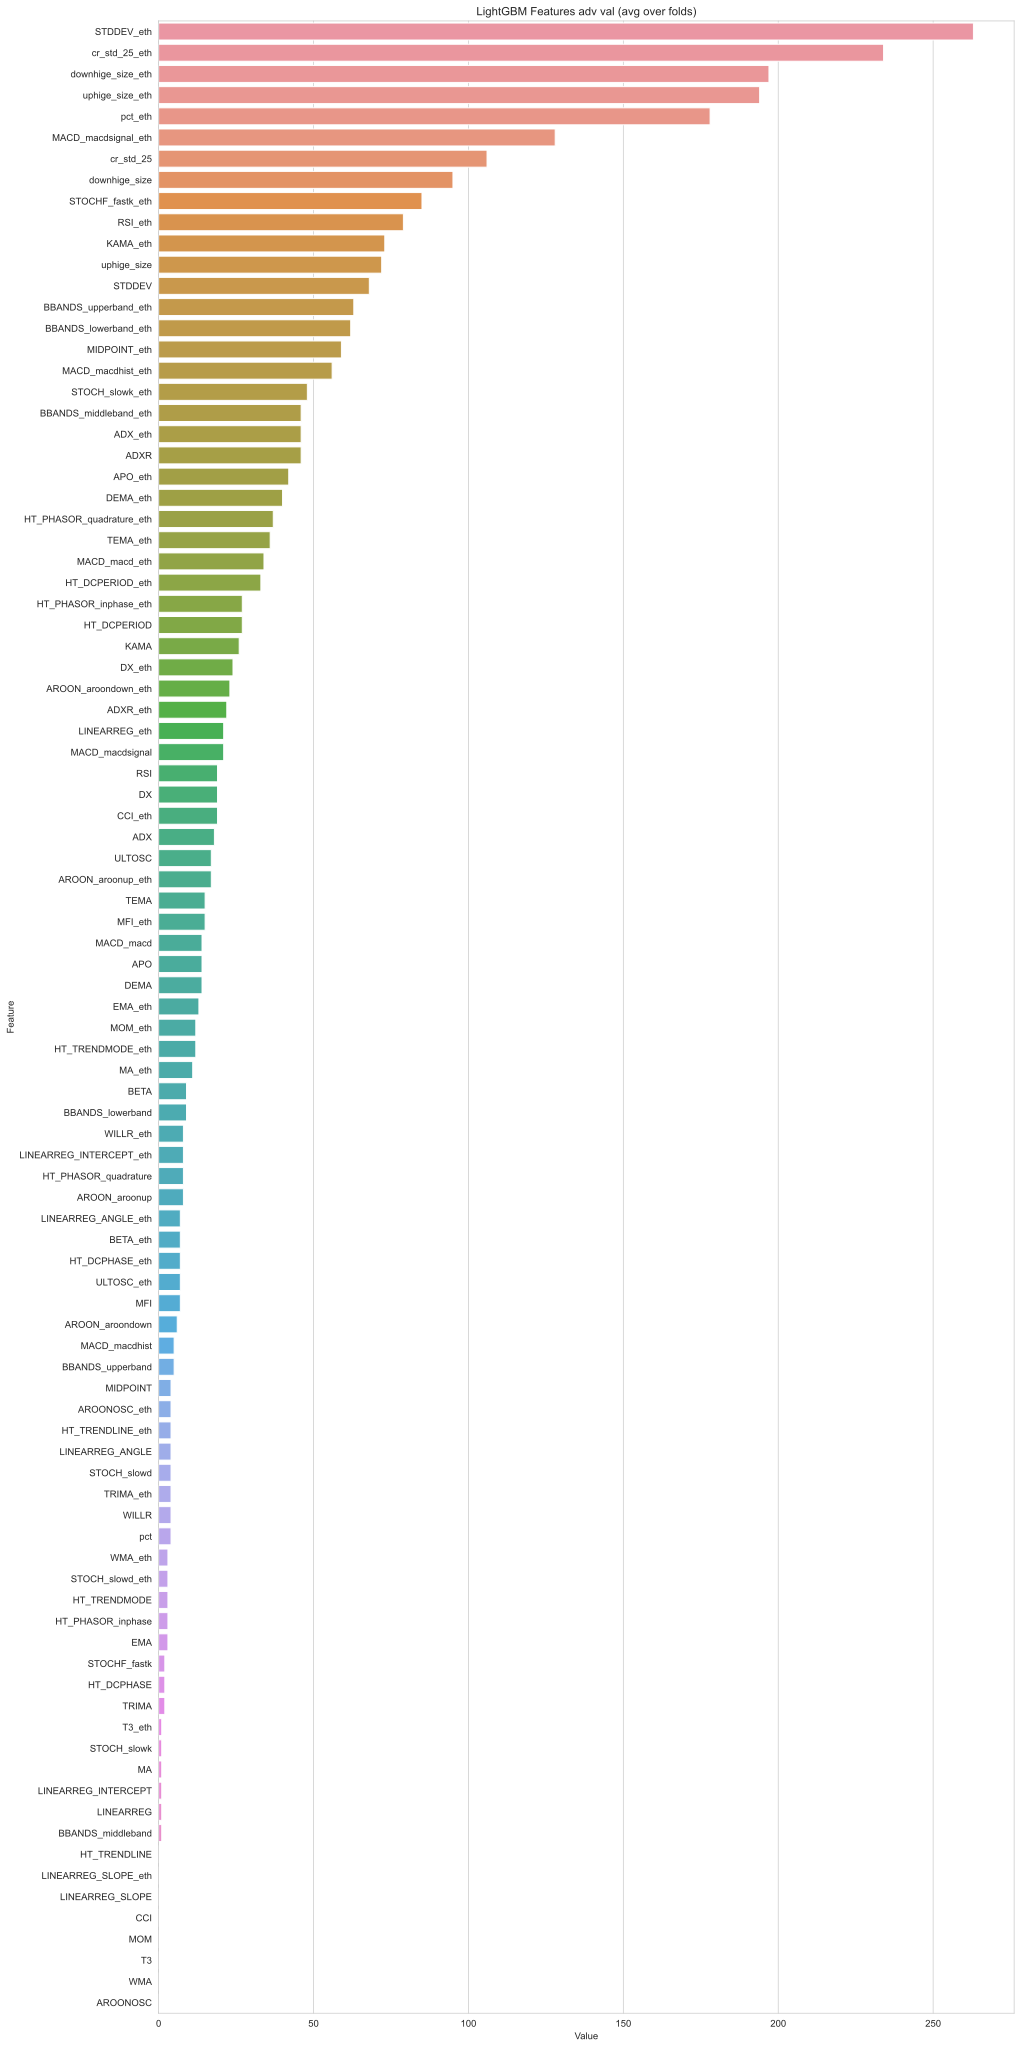

スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)
scores [0.92704778 0.92697894]
score mean, std 0.9270133615795062 3.442324454300261e-05


In [8]:
df = pd.read_pickle('df_features.pkl')

print('dfは特徴量が入ったDataFrame')
print('featuresは使う特徴量カラム名配列')

print('重要度表示。重要度が高いものは汎化性能に悪影響を与える可能性がある')
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)
model.fit(df[features], np.arange(df.shape[0]))
lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value','Feature'])
plt.figure(figsize=(15, 30))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()

print('スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)')
cv = KFold(n_splits=2, shuffle=True, random_state=0)
scores = cross_val_score(model, df[features], np.arange(df.shape[0]), scoring='r2', cv=cv)
print('scores', scores)
print('score mean, std', np.mean(scores), np.std(scores))

# FEP計算

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


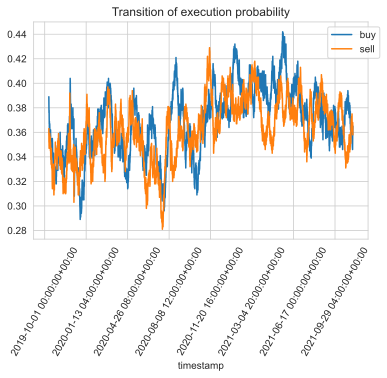

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


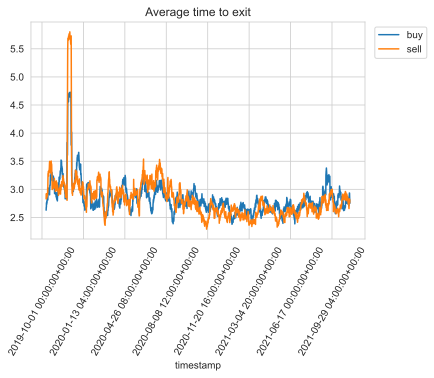

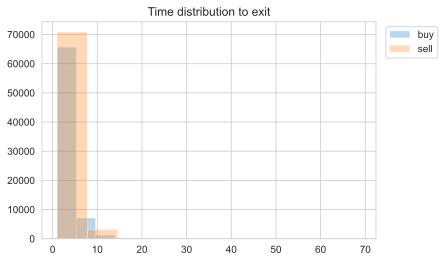

毎時刻、この執行方法でトレードした場合の累積リターン


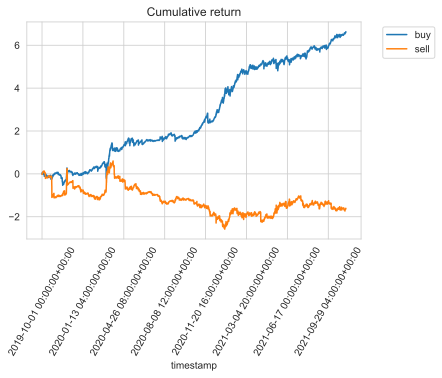

In [9]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 0.5

# ATRで指値距離を計算します
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['close'] - limit_price_dist
df['sell_price'] = df['close'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['low'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['high'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['low'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['high'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['close'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['close'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='buy', rot=60)
df['sell_executed'].rolling(1000).mean().plot(label='sell', rot=60)
plt.title('Transition of execution probability')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='buy', rot=60)
df['sell_fet'].rolling(1000).mean().plot(label='sell', rot=60)
plt.title('Average time to exit')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='buy')
df['sell_fet'].hist(alpha=0.3, label='sell')
plt.title('Time distribution to exit')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='buy', rot=60)
df['y_sell'].cumsum().plot(label='sell', rot=60)
plt.title('Cumulative return')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_y.pkl')

# 特徴量選択

### MICで特徴量のパラメータを選択

In [12]:
def search_feature_param(df, params: List[float]):
    df = df.copy()
    hilo = (df['high'] + df['low']) / 2

    for param in params:
        x = talib.EMA(df['close'], timeperiod=param) - hilo
        mic = calc_mic(x=x, y=df['y_buy'].values)
        print(f'param: {param}, mic: {mic}')

# df = pd.read_pickle('df_y.pkl')
# search_feature_param(df=df, params=[15])

param: 15, mic: 0.032302737239174144


0.03227525825699646

### Shapで特徴量のパラメータを選択

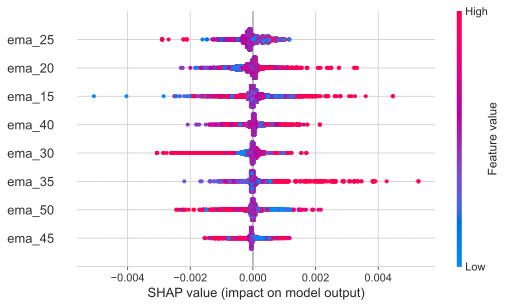

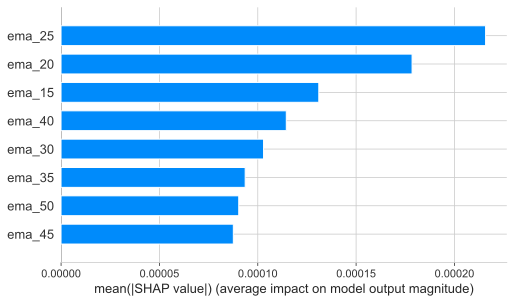

In [11]:
def calc_features_to_select(df, params: List[float]):
    hilo = (df['high'] + df['low']) / 2
    target_features = []
    for param in params:
        target_feature = f'ema_{param}'
        df[target_feature] = talib.EMA(df['close'], timeperiod=param) - hilo
        target_features.append(target_feature)

    return df, target_features

def exec_shap(df):
    params = [15, 20, 25, 30, 35, 40, 45, 50]
    df, target_features = calc_features_to_select(df, params)
    df = df.dropna()

    # モデル学習
    model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)
    model.fit(df[target_features], df['y_buy'])

    explainer = shap.TreeExplainer(model)  # 学習済みモデルを与える
    shap_values = explainer.shap_values(df[target_features])  # 学習データでSHAP値を計算

    # 目的変数と各特徴量の相関関係を表示
    shap.summary_plot(shap_values, df[target_features])
    # 目的変数に対する特徴量の寄与度を表示
    shap.summary_plot(shap_values, df[target_features], plot_type="bar")

# df = pd.read_pickle('df_y.pkl')
# exec_shap(df)


# ML

In [10]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

# アンサンブル (コメントアウトを外して性能を比較してみてください)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)

# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
# model.fit(df[features], df['y_buy'])
# joblib.dump(model, 'model_y_buy.xz', compress=True) 
# model.fit(df[features], df['y_sell'])
# joblib.dump(model, 'model_y_sell.xz', compress=True)

# 通常のCV
cv_indicies = list(KFold().split(df))
# ウォークフォワード法
# cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)


# 予測値が無い(nan)行をドロップ
df = df.dropna()

# print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
# df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='buy')
# df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='sell')
# (df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='buy + sell')
# plt.title('Cumulative return')
# plt.legend(bbox_to_anchor=(1.05, 1))
# plt.show()

df.to_pickle('df_fit.pkl')

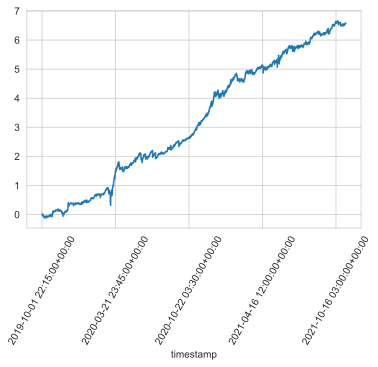

In [11]:
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='buy', rot=60)
plt.show()

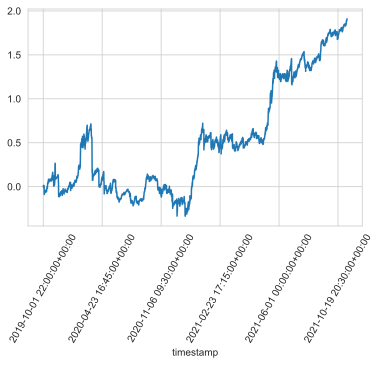

In [12]:
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='sell', rot=60)
plt.show()

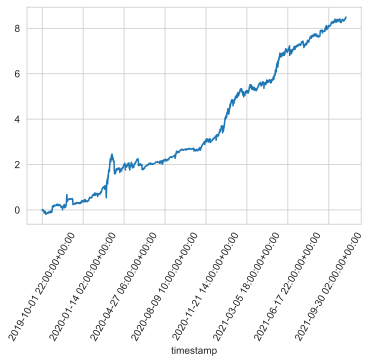

In [13]:
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='buy + sell', rot=60)
plt.show()

# バックテスト

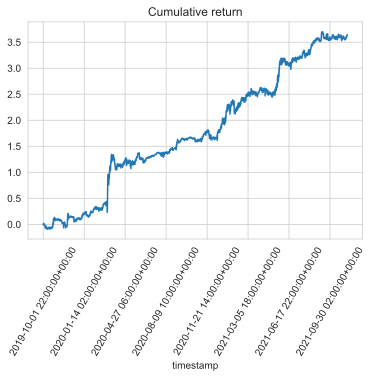

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


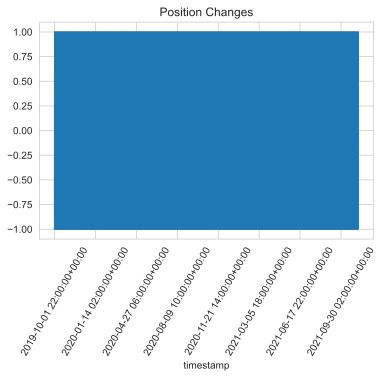

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


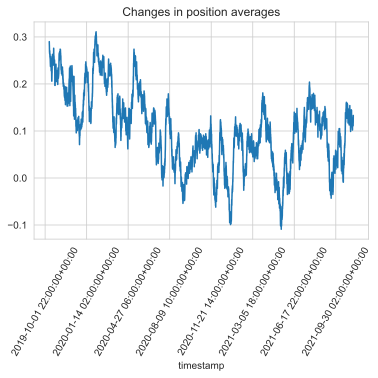

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


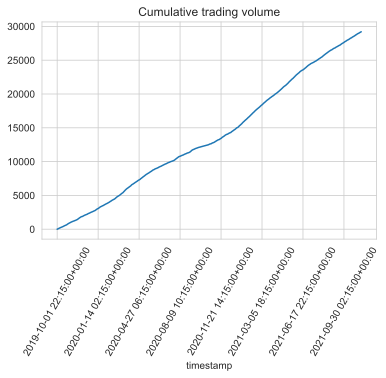

t検定
t値 3.779165307687145
p値 0.00015747790523122437
p平均法 n = 5
p平均 0.0891299835701288
エラー率 0.00014648323008200647


In [14]:
def backtest(
    cl=None, hi=None, lo=None, pips=None,
    buy_entry=None, sell_entry=None,
    buy_cost=None, sell_cost=None):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

df = pd.read_pickle('df_fit.pkl')

# バックテストで累積リターンと、ポジションを計算
df['cum_ret'], df['poss'] = backtest(
    cl=df['close'].values,
    buy_entry=df['y_pred_buy'].values > 0,
    sell_entry=df['y_pred_sell'].values > 0,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
)

df['cum_ret'].plot(rot=60)
plt.title('Cumulative return')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df['poss'].plot(rot=60)
plt.title('Position Changes')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df['poss'].rolling(1000).mean().plot(rot=60)
plt.title('Changes in position averages')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df['poss'].diff(1).abs().dropna().cumsum().plot(rot=60)
plt.title('Cumulative trading volume')
plt.show()

print('t検定')
x = df['cum_ret'].diff(1).dropna()
t, p = ttest_1samp(x, 0)
print('t値 {}'.format(t))
print('p値 {}'.format(p))

# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))